In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/lx/071yjxh93wx_hmdwq4r88s040000gn/T/ipykernel_80705/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station 
Measurement = Base.classes.measurement 

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


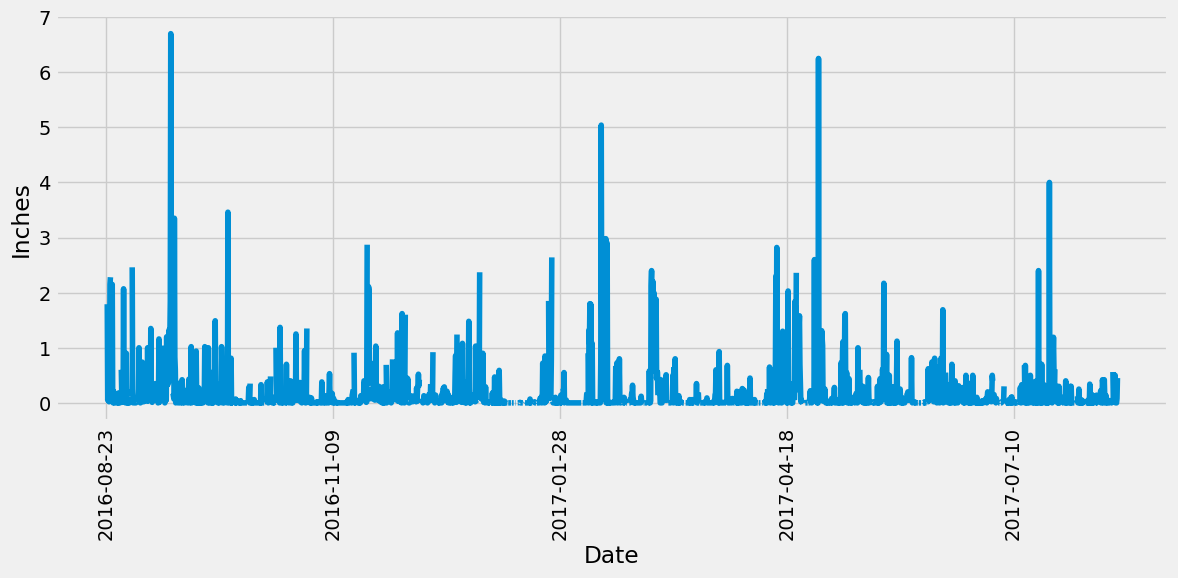

In [38]:
# Convert the most recent date to a Pandas datetime object
most_recent_date_1 = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in the dataset
one_year_ago = most_recent_date_1 - pd.DateOffset(years=1)

# Convert one_year_ago to string format to match the database date format
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df_sorted = df.sort_values(by='Date')

df_sorted.plot(x='Date', y='Precipitation', figsize=(12, 6), legend=False)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_df = pd.DataFrame(summary_statistics)
summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [54]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()

# Print the most active stations and their observation counts
for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to calculate the lowest, highest, and average temperature for the most active statio
most_active_station_id = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                 .filter(Measurement.station == most_active_station_id) \
                 .all()

# Display the results"
for result in results:
    print(f"Lowest Temperature: {result[0]}")
    print(f"Highest Temperature: {result[1]}")
    print(f"Average Temperature: {result[2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


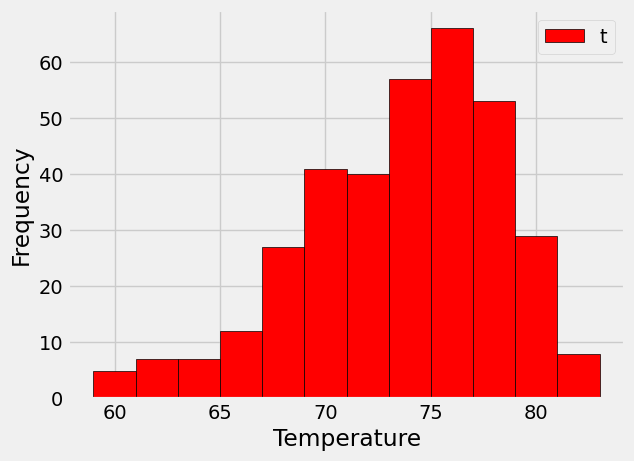

In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the station id of the most active station\n",
most_active_station = active_stations[0][0]

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs) \
                          .filter(Measurement.station == most_active_station) \
                          .filter(Measurement.date >= one_year_ago) \
                          .all()

# Extract the temperature values into a list"
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram"
plt.hist(temperatures, bins=12, color='red', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('tobs')
plt.show()


# Close Session

In [63]:
# Close Session
session.close()